In [4]:
import numpy as np
from PIL import Image
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

from stepbystep.v2 import StepByStep
from data_generation.rps import download_rps




2024-02-29 10:03:07.507843: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 10:03:07.705140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 10:03:07.705214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 10:03:07.717998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-29 10:03:07.749484: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 10:03:07.750363: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Data Preparation  
**ImageFolder**: Generic Dataset that you can use with your images provided, that they are organized into subfolders. Each subfolder is named after class. The root folder is `train` in below example.

train/paper/image1.png  
train/paper/image2.png

train/rock/image1.png  
train/rock/image2.png

train/scissors/image1.png  
train/scissors/image2.png

In [2]:
# download_rps('/home/anushka/Documents/Deep-Learning/Deep Learning with Pytorch')

In [3]:
 # Temporary Dataset
temp_transform=Compose(transforms=[Resize(28),ToTensor()])
temp_dataset=ImageFolder(root='rps',transform=temp_transform)

In [4]:
temp_dataset[2][0].shape,temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

## Standardization  
We need to know their mean and std!

In [5]:
# Temporary dataloader
temp_loader=DataLoader(dataset=temp_dataset,batch_size=16)


We need statistics(mean pixel and std) for each channel as required by the Normalize() function.

In [6]:
@staticmethod
def statistics_per_channel(images,labels):
    # NCHW
    n_samples,n_channels,n_height,n_weight=images.size()
    # Flatten HW into single dimention
    flatten_per_channel=images.reshape(n_samples,n_channels,-1)

    # compute statistics per each image per channel
    # Average pixel value per channel 
    means=flatten_per_channel.mean(axis=2) # n_samples, n_channels
    # Standard Deviation of pixel values per channel
    stds=flatten_per_channel.std(axis=2)

    # Adds up statistics of all images in a mini batch (1, n_channels)
    sum_means=means.sum(axis=0)
    sum_stds=stds.sum(axis=0)

    # Make a tensor of shape (1,n_channels) with the number of samples in a mini-batch
    n_samples=torch.tensor([n_samples]*n_channels).float()

    # stack the tensors on top of one another (3,n_channels)
    return torch.stack([n_samples,sum_means,sum_stds],axis=0)

setattr(StepByStep,'statistics_per_channel',statistics_per_channel)

In [7]:
first_images,first_labels=next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images,first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [8]:
# Get sum for the whole dataset
results=StepByStep.loader_apply(temp_loader,StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

Lets make a function that take dataloader and returns an instance of a Normalize function


In [9]:
@staticmethod
def make_normalizer(loader):
    total_samples,total_means,total_stds=StepByStep.loader_apply(loader,StepByStep.statistics_per_channel)
    norm_mean=total_means/total_samples
    norm_std=total_stds/total_samples
    return Normalize(mean=norm_mean,std=norm_std)

setattr(StepByStep,'make_normalizer',make_normalizer)

In [10]:
# Creating Normalizer Transform
normalizer=StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

## The Real Datasets

In [11]:
# Data preparation
composer=Compose(transforms=[Resize(28),ToTensor(),normalizer])

train_data=ImageFolder(root='rps',transform=composer)
val_data=ImageFolder(root='rps-test-set',transform=composer)

# Builds a loader of each set
train_loader=DataLoader(dataset=train_data,batch_size=16,shuffle=True)
val_loader=DataLoader(dataset=val_data,batch_size=16)



## Three Channel Convolutions


every filter has 3 channels since our image has 3 channels.

In [12]:
regions=np.array([5,0,8,1,9,5,6,0,2,0,5,4,8,1,9,4,8,1,4,2,0,6,3,0,5,2,8])
regions=regions.reshape(1,3,3,3)

In [13]:
regions.shape

(1, 3, 3, 3)

In [14]:
three_channel_filter=np.array([0,3,0,1,0,1,2,1,0,2,1,0,0,3,1,1,-1,0,1,0,3,-1,-2,0,2,0,1])
three_channel_filter=three_channel_filter.reshape(-1,3,3,3)
three_channel_filter.shape

(1, 3, 3, 3)

In [15]:
result=F.conv2d(input=torch.as_tensor(regions),weight=torch.as_tensor(three_channel_filter))
result,result.shape

(tensor([[[[41]]]]), torch.Size([1, 1, 1, 1]))

In [16]:
# Fancier Model
class CNN2(nn.Module):
    def __init__(self,n_filters,p=0.0):
        super(CNN2,self).__init__()
        self.n_filters=n_filters
        self.p=p
        # We will use n_filters as output channels for both convolutional blocks
        self.conv1=nn.Conv2d(in_channels=3,out_channels=n_filters,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=n_filters,out_channels=n_filters,kernel_size=3)

        # Create Linear layers
        self.fc1=nn.Linear(in_features=n_filters*5*5,out_features=50) # Hidden Layer
        self.fc2=nn.Linear(in_features=50,out_features=3) # Output Layer

        # Create dropout layers
        self.drop=nn.Dropout(self.p)

        # Fancier Model- Featurizer
    def featurizer(self,x):
        # First convolutional block
        # 3@28x28 -> n_filters@26x26 -> n_filters@13x13
        x=self.conv1(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2)

        # Second convolutional block
        # n_filters@13x13 -> n_filters@11x11 -> n_filters@5x5
        x=self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2)

        # input dimention: n_filters@5x5
        # output dimention: n_filtersx5x5
        x=nn.Flatten()(x)
        return x

    # Fancier Model- Classifier
    def classifier(self,x):
        # Hidden Layer: n_filters@5x5 -> 50
        if self.p>0:
            x=self.drop(x)
        x=self.fc1(x)
        x=F.relu(x)

        # output layer: 50 -> 3
        if self.p>0:
            x=self.drop(x)
        x=self.fc2(x)
        return x

    def forward(self,x):
        x=self.featurizer(x)
        x=self.classifier(x)
        return x

In [17]:
# # Fancier Model- Classifier
# def classifier(self,x):
#     # Hidden Layer: n_filters@5x5 -> 50
#     if self.p>0:
#         x=self.drop(x)
#     x=self.fc1(x)
#     x=F.relu(x)

#     # output layer: 50 -> 3
#     if self.p>0:
#         x=self.drop(x)
#     x=self.fc2(x)
#     return x

In [18]:
# def forward(self,x):
#     x=self.featurizer(x)
#     x=self.classifier(x)
#     return x

## Dropout

Sometimes model may rely on features specifically found on training set. Model may try to find an easy way out to achieve the target

In [19]:
# Feature normalization
dropping_model=nn.Sequential(nn.Dropout(p=0.5))


In [20]:
spaced_points=torch.linspace(0.1,1.1,11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [21]:
torch.manual_seed(44)

dropping_model.train()
output_train=dropping_model(spaced_points) # remianing elements will be adjusted by 1/p
output_train

tensor([0.0000, 0.4000, 0.0000, 0.8000, 0.0000, 1.2000, 1.4000, 1.6000, 1.8000,
        0.0000, 2.2000])

In [22]:
output_train/spaced_points

tensor([0., 2., 0., 2., 0., 2., 2., 2., 2., 0., 2.])

In [23]:
F.linear(output_train,weight=torch.ones(11),bias=torch.tensor(0)) # This would be 4.8000 withoput adjusting factor

tensor(9.4000)

Since There is no dropping in evaluation, It will produce slightly different results, 

In [24]:
dropping_model.eval()
output_eval=dropping_model(spaced_points) # There is no adjusting factor
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [25]:
F.linear(output_eval,weight=torch.ones(11),bias=torch.tensor(0))


tensor(6.6000)

Dropping is probabilistic

In [26]:
# torch.manual_seed(17)
# p=0.5
# distrib_outputs=torch.tensor([F.linear(F.dropout(spaced_points,p=p),weight=torch.ones(11),bias=torch.tensor(0)) for _ in range(1000)])


In [27]:
# distrib_outputs.reshape(-1,1).shape

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.histplot(distrib_outputs.reshape(-1,1),binrange=(0,20),bins=30)
# plt.show()

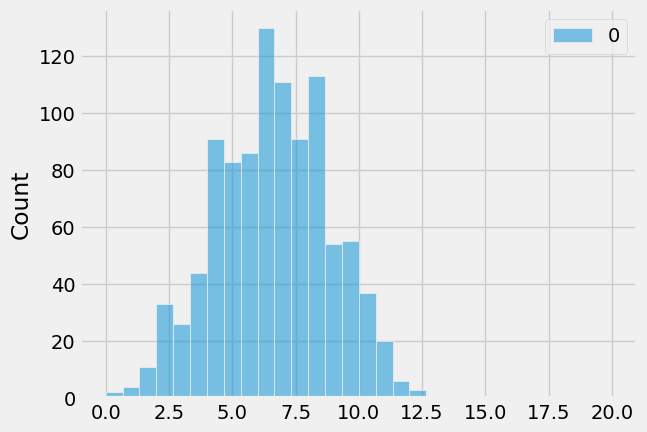

In [29]:
# torch.mean(distrib_outputs,axis=0) tensor(6.5694)

Output for simple linear layer with dropput will be between 0 and 13. Not exactly 6.6

In [30]:
# # Lets try drop of p=0.8
# distrib_outputs2=torch.tensor([F.linear(F.dropout(spaced_points,p=0.8),weight=torch.ones(11),bias=torch.tensor(0)) for _ in range(1000)])

# sns.histplot(distrib_outputs2.reshape(-1,1),binrange=(0,20),bins=30)
# plt.show()

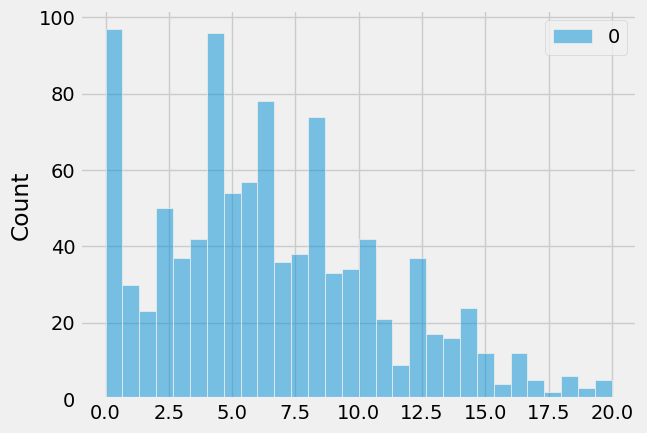

In [31]:
# # Lets try drop of p=0.2
# distrib_outputs3=torch.tensor([F.linear(F.dropout(spaced_points,p=0.2),weight=torch.ones(11),bias=torch.tensor(0)) for _ in range(1000)])

# sns.histplot(distrib_outputs3.reshape(-1,1),binrange=(0,20),bins=30)
# plt.show()

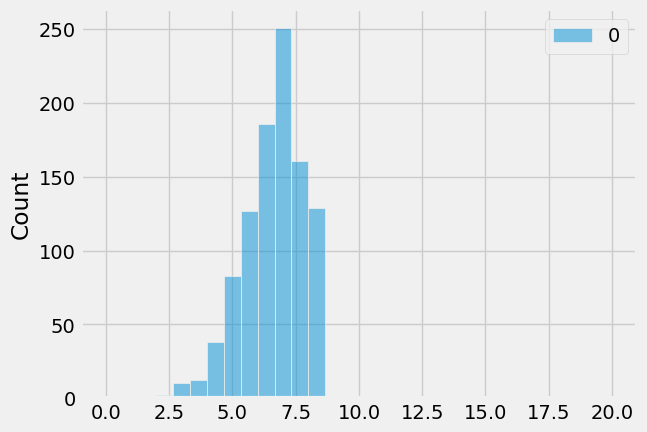

The variance of the distribution of outputs grows with dropout probability

## Tow Diemntional Dropout

Specific dropout with convolutional layers: instead of drooping individual inputs, it drops entire filters. Randomly dropping pixel values pixels doesnt do much since adjacent pixels are strongly correlated.

## Model Configuration

In [32]:
torch.manual_seed(13)
model_cnn2=CNN2(n_filters=5,p=0.3)
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2=optim.Adam(model_cnn2.parameters(),lr=3e-4)

In [33]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

## Model Training

In [34]:
sbs_cnn2=StepByStep(model_cnn2,multi_loss_fn,optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader,val_loader)
sbs_cnn2.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
fig=sbs_cnn2.plot_losses()

### Accuracy

In [36]:
StepByStep.loader_apply(val_loader,sbs_cnn2.correct)

tensor([[ 89, 124],
        [118, 124],
        [117, 124]])

In [37]:
print(f"Accuracy: {(torch.sum(StepByStep.loader_apply(val_loader,sbs_cnn2.correct),axis=0)[0]/torch.sum(StepByStep.loader_apply(val_loader,sbs_cnn2.correct),axis=0)[1])*100:.2f} %")

Accuracy: 87.10 %


## Regularizing Effect

In [38]:
torch.manual_seed(13)
# model config
model_cnn2_nodrop=CNN2(n_filters=5,p=0.0)
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2=optim.Adam(model_cnn2_nodrop.parameters(),lr=3e-4)

# model training
sbs_cnn2_nodrop=StepByStep(model_cnn2_nodrop,multi_loss_fn,optimizer_cnn2)
sbs_cnn2_nodrop.set_loaders(train_loader,val_loader)
sbs_cnn2_nodrop.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
fig=sbs_cnn2_nodrop.plot_losses()

In [40]:
# No dropout model Accuracy
print(f"NO dropout model Train Accuracy:{(StepByStep.loader_apply(train_loader,sbs_cnn2_nodrop.correct).sum(axis=0)[0]/StepByStep.loader_apply(train_loader,sbs_cnn2_nodrop.correct).sum(axis=0)[1])*100:.2f}%")
print(f"NO dropout model Validation Accuracy:{(StepByStep.loader_apply(val_loader,sbs_cnn2_nodrop.correct).sum(axis=0)[0]/StepByStep.loader_apply(val_loader,sbs_cnn2_nodrop.correct).sum(axis=0)[1])*100:.2f}%")
# droput model Acuuracy
print(f"\nDropout model Train Accuracy:{(StepByStep.loader_apply(train_loader,sbs_cnn2.correct).sum(axis=0)[0]/StepByStep.loader_apply(train_loader,sbs_cnn2.correct).sum(axis=0)[1])*100:.2f}%")
print(f"Dropout model Validation Accuracy:{(StepByStep.loader_apply(val_loader,sbs_cnn2.correct).sum(axis=0)[0]/StepByStep.loader_apply(val_loader,sbs_cnn2.correct).sum(axis=0)[1])*100:.2f}%")

NO dropout model Train Accuracy:100.00%
NO dropout model Validation Accuracy:78.49%

Dropout model Train Accuracy:99.33%
Dropout model Validation Accuracy:87.10%


## Visualizing Filters

In [41]:
model_cnn2.conv1.weight.shape # 5 filters for each input channel

torch.Size([5, 3, 3, 3])

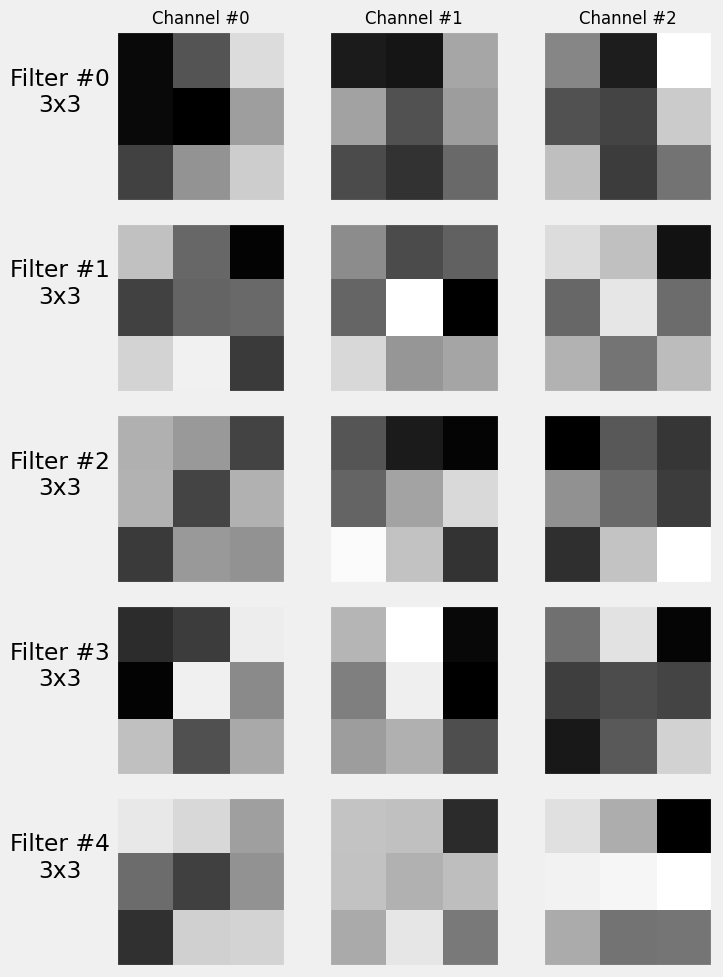

In [42]:
fig=sbs_cnn2.visualize_filters('conv1')

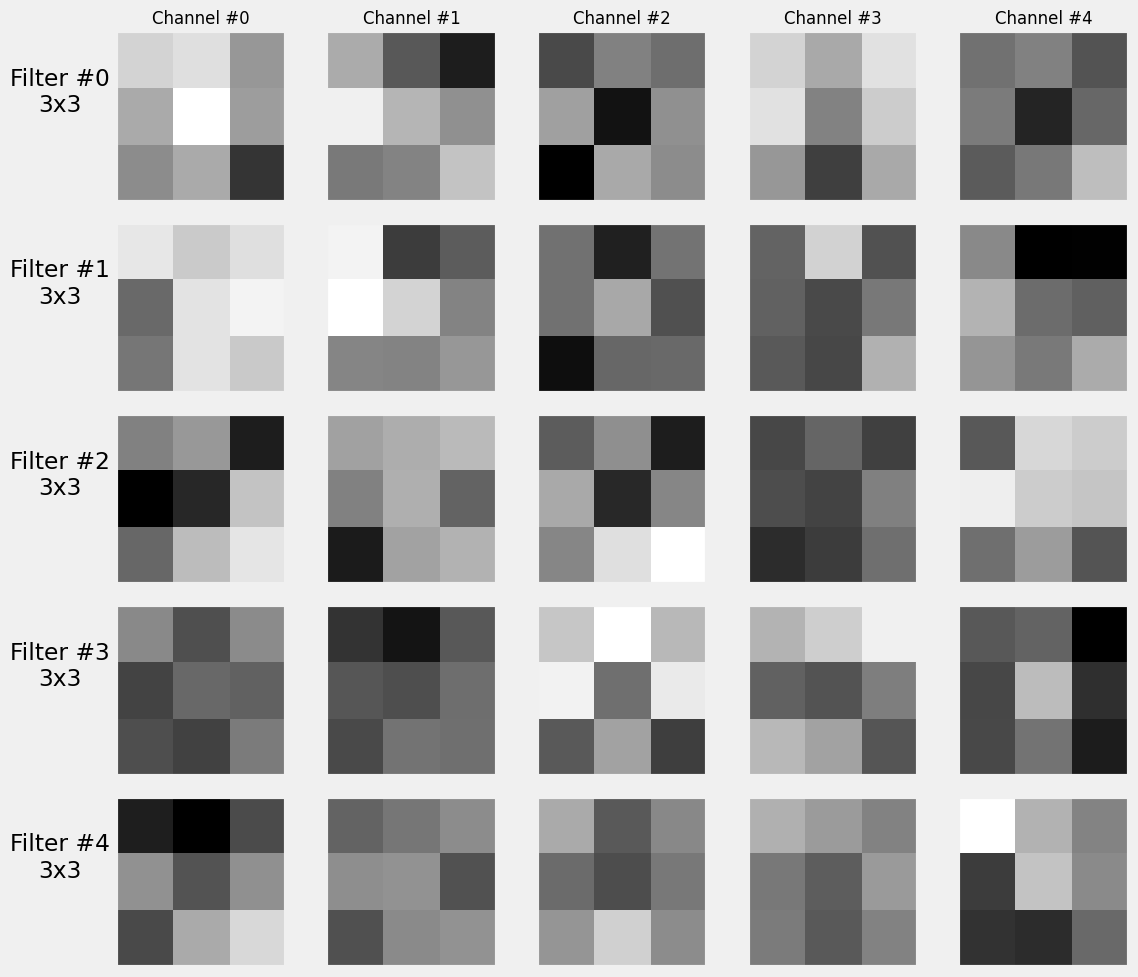

In [43]:
fig=sbs_cnn2.visualize_filters('conv2')

## Learning Rates

* If the LR is too low, model doesn't learn much.
* If the LR is too high, model doesn't converge to a solution.

### Finding LR

In [44]:
def make_lr_fn(start_lr,end_lr,num_iter,step_mode='exp'):
    if step_mode=='linear':
        factor=(end_lr/start_lr-1)/num_iter
        def lr_fn(iteration):
            return 1+iteration*factor # returns the multiplying factor
    
    else:
        factor=(np.log(end_lr)-np.log(start_lr))/num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    
    return lr_fn

In [45]:
start_lr=0.01
end_lr=0.1
num_iter=10
lr_fn=make_lr_fn(start_lr,end_lr,num_iter,step_mode='exp')

In [46]:
lr_fn(np.arange(num_iter+1)) # multiplying factor

array([ 1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

In [47]:
start_lr*lr_fn(np.arange(num_iter+1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

In [48]:
dummy_model=CNN2(n_filters=5,p=0.3)
dummy_optimizer=optim.Adam(dummy_model.parameters(),lr=start_lr)
dummy_scheduler=LambdaLR(optimizer=dummy_optimizer,lr_lambda=lr_fn)

In [49]:
dummy_optimizer.step()
dummy_scheduler.step()

In [50]:
# After 1 step lr should have been updated to match the second value
dummy_scheduler.get_last_lr()

[0.012589254117941673]

In [51]:
dummy_optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.012589254117941673,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'initial_lr': 0.01,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

In [52]:
def lr_range_test(self,data_loader,end_lr,num_iter=100,step_mode='exp',alpha=0.05,ax=None):
    # The test updates both model and optimizer
    # We need to store their initial states to restore them
    previous_states={'model':deepcopy(self.model.state_dict()),
                     'optimizer':deepcopy(self.optimizer.state_dict())}
    # Retrives the learning rate set in the optimizer
    start_lr=self.optimizer.state_dict()['param_groups'][0]['lr']

    # Builds a custom funtion and corresponding scheduler
    lr_fn=make_lr_fn(start_lr,end_lr,num_iter)
    scheduler=LambdaLR(optimizer=self.optimizer,lr_lambda=lr_fn)

    # variables for tracking results and iterations
    tracking={'loss':[],'lr':[]}
    iteration=0

    # If there are more iterations than mini batches in the loader, it willl have to loop over it more than once
    while (iteration<num_iter):
        # The typical mini batch inner loop
        for x_batch,y_batch in data_loader:
            x_batch=x_batch.to(self.device)
            y_batch=y_batch.to(self.device)

            # step 1
            yhat=self.model(x_batch)
            # step 2
            loss=self.loss_fn(yhat,y_batch)
            # step 3
            loss.backward()

            # Here we keep tack of losses (smoothed) and learning rates
            tracking['lr'].append(scheduler.get_last_lr()[0])
            if iteration==0:
                tracking["loss"].append(loss.item())
            else:
                prev_loss=tracking["loss"][-1]
                smoothed_loss=(alpha*loss.item()+(1-alpha)*prev_loss)
                tracking["loss"].append(smoothed_loss)
            iteration+=1

            # Number of iteration reached
            if iteration==num_iter:
                break

            # step 4
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

    # Restore the original states
    self.optimizer.load_state_dict(previous_states['optimizer'])
    self.model.load_state_dict(previous_states['model'])

    if ax is None:
        fig,ax=plt.subplots(1,1,figsize=(6,4))
    else:
        fig=ax.get_figure()
    
    ax.plot(tracking['lr'],tracking['loss']) 
    if step_mode=='exp':
        ax.set_xscale('log')
        ax.set_xlabel('Learning_Rate')
        ax.set_ylabel("Loss")
        fig.tight_layout()
        return tracking, fig

setattr(StepByStep,'lr_range_test',lr_range_test)

The technique is supposed to applied on untrained model

In [53]:
# Model config
torch.manual_seed(13)
new_model=CNN2(n_filters=5,p=0.3)
multi_loss_fn=nn.CrossEntropyLoss(reduction='mean')
new_optimizer=optim.Adam(new_model.parameters(),lr=3e-3)


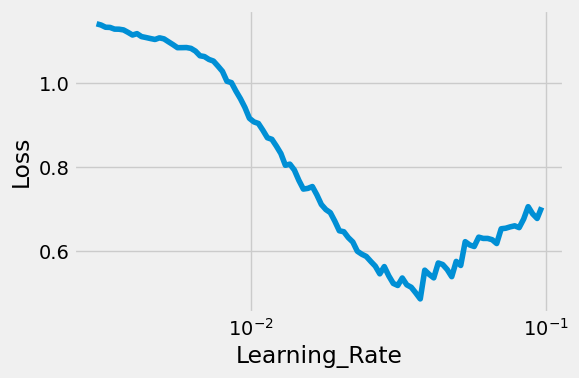

In [54]:
sbs_new=StepByStep(new_model,multi_loss_fn,new_optimizer)
tracking,fig=sbs_new.lr_range_test(train_loader,end_lr=1e-1,num_iter=100)


In [55]:
def set_optimizer(self,optimizer):
    self.optimizer=optimizer

setattr(StepByStep,'set_optimizer',set_optimizer)

In [56]:
# Updating LR and Model Training
new_optimizer=optim.Adam(new_model.parameters(),lr=5e-3)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader,val_loader)
sbs_new.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

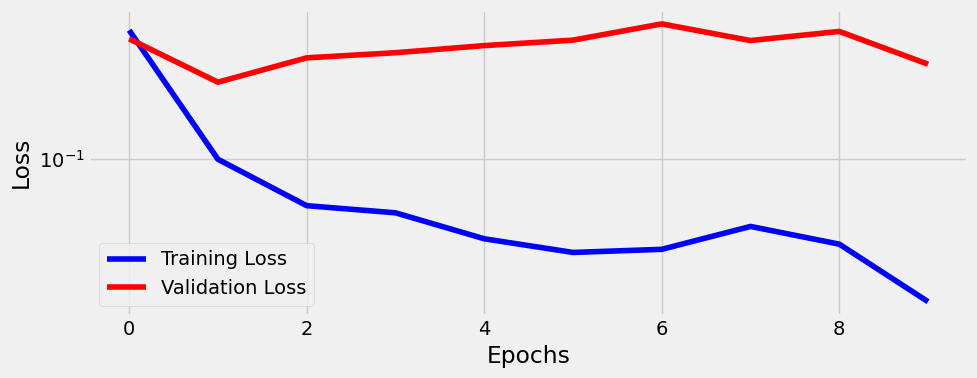

In [57]:
sbs_new.plot_losses()

In [58]:
print(f"New model Validation Accuracy:{(StepByStep.loader_apply(val_loader,sbs_new.correct).sum(axis=0)[0]/StepByStep.loader_apply(val_loader,sbs_new.correct).sum(axis=0)[1])*100:.2f}%")

New model Validation Accuracy:88.98%


In [59]:
# !pip install torch-lr-finder

In [60]:
from torch_lr_finder import LRFinder

/home/anushka/anaconda3/envs/torch/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.02E-03


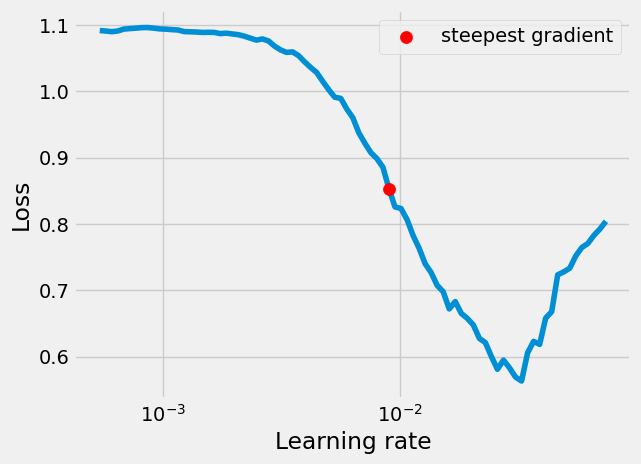

In [61]:
torch.manual_seed(11)
new_model=CNN2(n_filters=5,p=0.3)
multi_log_fn=nn.CrossEntropyLoss(reduction='mean')
new_optimizer=optim.Adam(new_model.parameters(),lr=3e-4)
device= 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder=LRFinder(new_model,new_optimizer,multi_loss_fn,device=device)
lr_finder.range_test(train_loader,end_lr=0.1,num_iter=100)
lr_finder.plot(log_lr=True)
lr_finder.reset()

## Adaptive Learning Rate

Adam doesnt adpt  the learning rate, but adapts the gradients.  
Adam Combines characteristics of two other optimization strategies.  
1. RMSprop: Adapts learning rate for individual parameters
2. Momentum: Speedup the process by remembering the past directions  

It scales the gradients using a moving average of squared gradients. 


### Simple Moving average  
$$
\text{MA}_t = \frac{1}{periods} \sum_{i=t}^{(t-periods+1)} x_i

$$

### Average age of moving average
$$
\text{average age}_{MA}=\frac{\sum_{i=1}^{periods} i}{periods}=\frac{periods+1}{2}
$$

### EWMA  
This has 2 input values.
* EWMA in previous step 
* current value

$$\text{EWMA}_t(\alpha,x)=\alpha x_t+(1-\alpha)EWMA_{t-1}(\alpha,x) \\$$
$$\text{EWMA}_t(\beta,x)=(1-\beta) x_t+(\beta)EWMA_{t-1}(\beta,x)$$

Lets Expand 1st equation  
$$
\text{EWMA}_t(\alpha,x)=\alpha x_t+(1-\alpha)(\alpha x_{t-1}+(1-\alpha)EWMA_{t-2}(\alpha,x)) \\ 

\text{EWMA}_t(\alpha,x)=\alpha (x_{t}+(1-\alpha)^1 (x_{t-1})+(1-\alpha)^2 (x_{t-2})+(1-\alpha)^3 (x_{t-3})+...)

$$


First element is taken at face value. Remaining elements are discounted based on corresponding lags  

lag : `distance in units of time from current value`

### Lag based EWMA  
$$
\text{EWMA}_t(\alpha,x)=\alpha \sum_{lag=0}^{T-1} (1-\alpha)^{lag} x_{t-lag} \\
$$  

T is the number of observed values. EWMA takes every single value into account.

zero lag is corresponding to 1 unit of time; 
$$lag=t-1 (\text{t=1 represent the current moment}) \\ $$
$$
\text{average age}_{EWMA}(\alpha,x)=\alpha \sum_{lag=0}^{T-1} (1-\alpha)^{lag} (lag+1) =\frac{1}{\alpha}\\
$$  

In [70]:
alpha=1/3
t=np.arange(1,100+1)
age=alpha*sum(((1-alpha)**(t-1))*t) # t-1 corresponds to age of data point(t=t) relative to the current time point(t=1)
age

3.0000000000000027

$$\text{Average age}=\frac{periods+1}{2}=\frac{1}{\alpha} \\
periods=\frac{2}{\alpha}-1
$$


In [36]:
def EWMA(past_value,current_value,alpha):
    return alpha*current_value+(1-alpha)*past_value


In [37]:
# Compute EWMA over a series of values given a period
def calc_ewma(values,period):
    alpha=2/(period+1)
    result=[]
    for v in values:
        try:
            prev_value=result[-1]
        except IndexError:
            prev_value=0
        
        new_value=EWMA(past_value=prev_value,current_value=v,alpha=alpha)
        result.append(new_value)
    return np.array(result)

In its first steps, average will be biased

$$
\text{Bias Corrected EWMA}_t(x,\beta)=\frac{1}{1-\beta^t}EWMA_t(x,\beta)
$$

In [38]:
def correction(average_value,beta,steps):
    return (1/(1-beta**steps))*average_value

In [39]:
def calc_corrected_ewma(values,period):
    ewma=calc_ewma(values,period)

    alpha=2/(period+1)
    beta=1-alpha

    result=[]
    for step,v in enumerate(values):
        adj_value=correction(ewma,beta,step+1)
        result.append(adj_value)

    return np.array(result)

$$
\text{Adapted Gradient}=\frac{\text{Bias Corrected EWMA}(\beta_1,gradients)}{\sqrt{\text{Bias Corrected EWMA}(\beta_2,gradients^2)}+e} \\
\text{Here are adams default values } \beta_1, \beta_2 \\
\beta_1=0.9 \\
\beta_2=0.999 \\
e=10^{-8} (\text{for preventing numerical issues})
$$

$\text{So it is a short term average for smoothing gradients}$


for each beta1 and beta2, we compute 2 EWMAs.  


$$
SGD: param_t=param_{t-1}-\eta (gradient_t) \\
Adam: param_t=param_{t-1}-\eta (\text{Adapted gradient}_t )\\
$$

## Adam

```python
optimizer=optim.Adam(params=model.parameters(),
                     lr=0.1,
                     betas=(0.9,0.999),
                     eps=1e-8)

```

$$\text{L2 Regularization adds penalty to the loss function: loss=}\frac{\sum_{i}^{n} (y_i-y_ipred)^2+\lambda [w_1^2+w_2^2+...+w_d^2]}{n}$$

### Visualizing adapted Gradients

In [79]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v2.py


In [80]:
# model config
torch.manual_seed(42)
model=nn.Sequential()
model.add_module('linear',nn.Linear(1,1))
optimizer=optim.Adam(model.parameters(),lr=0.1)
loss_fn=nn.MSELoss(reduction='mean')

In [81]:
setattr(StepByStep,'_gradients',{})

def capture_gradients(self,layers_to_hook):
    if not isinstance(layers_to_hook,list):
        layers_to_hook=[layers_to_hook]

    modules=list(self.model.named_modules())
    self._gradients={}

    def make_log_fn(name,parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return None
        return log_fn
    
    for name,layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name:{}})
            for parm_id,p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id:[]})
                    log_fn=make_log_fn(name,parm_id)
                    self.handles[f'{name}.{parm_id}.grad']=p.register_hook(log_fn) # register hook() register a backward hook to a tensor
    return

setattr(StepByStep,'capture_gradients',capture_gradients)


In [82]:
# Model training
sbs_adam=StepByStep(model, loss_fn,optimizer)
sbs_adam.set_loaders(train_loader,val_loader)
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()



  0%|          | 0/10 [00:00<?, ?it/s]

There are two series of 50 gradients (5 mini batches, 10 epochs)

In [83]:
gradients=np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients=calc_corrected_ewma(gradients,19)
corrected_sq_gradients=calc_corrected_ewma(np.power(gradients,2),1999)

adapted_gradients=(corrected_gradients/(np.sqrt(corrected_sq_gradients)+1e-8))

In [95]:
optimizer.state_dict() # exp_avg: uncorrected EWMA for gradients

{'state': {0: {'step': tensor(50.),
   'exp_avg': tensor([[-0.0062]]),
   'exp_avg_sq': tensor([[0.0033]])},
  1: {'step': tensor(50.),
   'exp_avg': tensor([0.0405]),
   'exp_avg_sq': tensor([0.0097])}},
 'param_groups': [{'lr': 0.1,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

In [96]:
optimizer.state_dict()['state']

{0: {'step': tensor(50.),
  'exp_avg': tensor([[-0.0062]]),
  'exp_avg_sq': tensor([[0.0033]])},
 1: {'step': tensor(50.),
  'exp_avg': tensor([0.0405]),
  'exp_avg_sq': tensor([0.0097])}}

In [99]:
calc_ewma(gradients,19)[-1],calc_ewma(np.power(gradients,2),1999)[-1]

(-0.006161476466002255, 0.003308466907084168)

### Capture parameters"

In [121]:
setattr(StepByStep,'_parameters',{})

def capture_parameters(self,layers_to_hook):
    if not isinstance(layers_to_hook,list):
        layers_to_hook=[layers_to_hook]

    modules=list(self.model.named_modules())
    layer_names={layer:name for name,layer in modules}
    self._parameters={}

    for name, layer in modules:
        if name in layers_to_hook:
            self._parameters.update({name:{}})
            for parm_id, p in layer.named_parameters():
                self._parameters[name].update({parm_id: []})

    def fw_hook_fn(layer,inputs,outputs):
        name=layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())

    self.attach_hooks(layers_to_hook,fw_hook_fn)
    return 

setattr(StepByStep,'capture_parameters',capture_parameters)
                    

$$
\textbf{SGD Optimizer} \\
\text{momentum} = (1-\text{dampening}) \cdot \text{grad}_t + \beta \cdot \text{momentum}_{t-1}
$$

In [124]:
optimizer=optim.SGD(model.parameters(),lr=0.1)
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.1,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}

$$
\text{SGD with Momentum: } \text{param}_t=\text{param}_{t-1}-\eta \cdot \text{momentum}_t
$$